# 1. Import Libraries 

In [1]:
import os
import glob
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import seaborn as sns
import altair as alt

from sklearn.model_selection import train_test_split

#model performance
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay,top_k_accuracy_score, balanced_accuracy_score, f1_score, recall_score 

#Scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#Distnce Matrix
from scipy.spatial import distance_matrix, distance
#Supress warnings
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore')

from sklearnex import patch_sklearn
patch_sklearn()

from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC, NuSVC

from sklearn.manifold import TSNE

import Utility_functions as ut
import Custom_Evaluation as ce

import random
random.seed(10) 

data_dir = 'C:/Dissertation/Data/'


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# 2. Import Data

In [2]:
Final_Images_df, predicate_df = ut.AWA2DataLoader(data_dir, data_type = "ResNet101-Features", 
                                                  Resnet101Type = 1, 
                                                  animal_attributes = 'AwA2', 
                                                  VectorType = 'Binary')

#data_type options
#1. "ResNet101-Features" to load Extracted Resnet101 features Avg. Time - 12 secs
#2. "Images"

#Resnet101Type
# 1 - Using Resnet Features provided with data
# 2 - Using Resnet Features extracted by Abhimanyu Acharya using a pretrainied Resnet101

# animal_attribute
#1. "AwA2" - As provided with AwA2 data
#2. "Custom Animal Attribute KG" - Custom KGs
#3. "Custom Animal Attribute + Taxonomy KG" - Custom KGs
#4. "Word2Vec" - word2vec-google-news-300
#5. "Dbnary" - Dbnary Knowledge Graph/Wiktionary (KGVec2Go Wiktionary/DBnary)
#6. "DBpedia" - DBPedia Knowledge Graph (KGVec2Go Classic RDF2vec: 500 walks, depth: 4, SG, 200 dimensions)

Using Resnet101 Features provided with data
Animal Attributes Included - Binary Vector
Execution time: 11.19719934463501 seconds


# 3. Split Data in Predefined Test, Train & Validation for ZSL

In [3]:
trainval_df, TrainData01, ValData01, TrainData02, ValData02, TrainData03, ValData03, Seen_test_df, Unseen_test_df = ut.TestTrainValsplitdata_dir(data_dir, Final_Images_df)

  Training - Validation Split 01 
 Train Classes  
 Number of Classes 27 
 ['antelope' 'buffalo' 'chihuahua' 'collie' 'cow' 'elephant' 'fox'
 'german+shepherd' 'grizzly+bear' 'hippopotamus' 'humpback+whale'
 'killer+whale' 'lion' 'mouse' 'otter' 'persian+cat' 'pig' 'polar+bear'
 'rhinoceros' 'siamese+cat' 'skunk' 'spider+monkey' 'squirrel' 'tiger'
 'weasel' 'wolf' 'zebra'] 

 Validation Classes  
 Number of Classes 13 
 ['beaver' 'chimpanzee' 'dalmatian' 'deer' 'giant+panda' 'gorilla'
 'hamster' 'leopard' 'mole' 'moose' 'ox' 'rabbit' 'raccoon'] 

  Training - Validation Split 02 
 Train Classes  
 Number of Classes 27 
 ['buffalo' 'chimpanzee' 'collie' 'cow' 'deer' 'elephant' 'german+shepherd'
 'giant+panda' 'gorilla' 'hamster' 'hippopotamus' 'humpback+whale'
 'leopard' 'lion' 'mole' 'moose' 'mouse' 'polar+bear' 'rabbit' 'raccoon'
 'rhinoceros' 'siamese+cat' 'spider+monkey' 'squirrel' 'tiger' 'weasel'
 'wolf'] 

 Validation Classes  
 Number of Classes 13 
 ['antelope' 'beaver' 'chihua

# 4. Define Dependent and Independent variables 

In [4]:
# Pre defined Test split 01
X1 = TrainData01.iloc[:,1:2049]
y1 = TrainData01.iloc[:,2051:2136]

# Pre defined Test split 02
X2 = TrainData02.iloc[:,1:2049]
y2 = TrainData02.iloc[:,2051:2136]

# Pre defined Test split 03
X3 = TrainData03.iloc[:,1:2049]
y3 = TrainData03.iloc[:,2051:2136]

X_finaltrain = trainval_df.iloc[:,1:2049]
y_finaltrain = trainval_df.iloc[:,2051:2136]

In [5]:
#Train val split for testing projection network
X_train1,X_val_seen_classes1,y_train1,y_val_seen_classes1 = train_test_split(X1,y1,stratify=y1,test_size=0.1,random_state = 0)

X_train2,X_val_seen_classes2,y_train2,y_val_seen_classes2 = train_test_split(X2,y2,stratify=y2,test_size=0.1,random_state = 0)

X_train3,X_val_seen_classes3,y_train3,y_val_seen_classes3 = train_test_split(X3,y3,stratify=y3,test_size=0.1,random_state = 0)

#Stratify Final train data 
X_train_final,X_val_seen_classes_final,y_train_final,y_val_seen_classes_final = train_test_split(X_finaltrain,y_finaltrain,stratify=y_finaltrain,test_size=0.002,random_state = 0)

# 5. Define Animal Attributes

In [6]:
animal_attributes_df = pd.read_csv("C:/Dissertation/Data/AwA2-data/Animals_with_Attributes2/predicates.txt", sep = '\t',header = None, names = ['predicates'])
animal_attributes_list = animal_attributes_df['predicates'].tolist()
print(animal_attributes_list)

['black', 'white', 'blue', 'brown', 'gray', 'orange', 'red', 'yellow', 'patches', 'spots', 'stripes', 'furry', 'hairless', 'toughskin', 'big', 'small', 'bulbous', 'lean', 'flippers', 'hands', 'hooves', 'pads', 'paws', 'longleg', 'longneck', 'tail', 'chewteeth', 'meatteeth', 'buckteeth', 'strainteeth', 'horns', 'claws', 'tusks', 'smelly', 'flys', 'hops', 'swims', 'tunnels', 'walks', 'fast', 'slow', 'strong', 'weak', 'muscle', 'bipedal', 'quadrapedal', 'active', 'inactive', 'nocturnal', 'hibernate', 'agility', 'fish', 'meat', 'plankton', 'vegetation', 'insects', 'forager', 'grazer', 'hunter', 'scavenger', 'skimmer', 'stalker', 'newworld', 'oldworld', 'arctic', 'coastal', 'desert', 'bush', 'plains', 'forest', 'fields', 'jungle', 'mountains', 'ocean', 'ground', 'water', 'tree', 'cave', 'fierce', 'timid', 'smart', 'group', 'solitary', 'nestspot', 'domestic']


# 6. Load Taxonomy Information

In [7]:
taxonomy_df = pd.read_csv("C:/Dissertation/Data/Mammal Taxonomy/Mammal Taxonomy_noduplicates.csv")
taxonomy_df.drop(['subgenus','biogeographicRealm','CMW_sciName'], axis = 1, inplace = True)
taxonomy_df.head()

,sciName,animal_label,animal_class,mainCommonName,otherCommonNames,class,infraclass,magnorder,superorder,order,suborder,infraorder,parvorder,superfamily,family,subfamily,tribe,genus
0,Antilope_cervicapra,1,antelope,Blackbuck,Indian Antelope,Mammalia,Placentalia,Boreoeutheria,Laurasiatheria,ARTIODACTYLA,RUMINANTIA,PECORA,NaN,NaN,BOVIDAE,ANTILOPINAE,ANTILOPINI,Antilope
1,Ursus_arctos,2,grizzly+bear,Brown Bear,Grizzly Bear|Kodiak Bear,Mammalia,Placentalia,Boreoeutheria,Laurasiatheria,CARNIVORA,CANIFORMIA,ARCTOIDEA,NaN,URSOIDEA,URSIDAE,URSINAE,NaN,Ursus
2,Orcinus_orca,3,killer+whale,Killer Whale,Orca,Mammalia,Placentalia,Boreoeutheria,Laurasiatheria,ARTIODACTYLA,WHIPPOMORPHA,CETACEA,ODONTOCETI,DELPHINOIDEA,DELPHINIDAE,INCERTAE SEDIS,NaN,Orcinus
3,Aplodontia_rufa,4,beaver,Mountain Beaver,Boomer|Sewellel|Point Arena Mountain Beaver|Po...,Mammalia,Placentalia,Boreoeutheria,Euarchontoglires,RODENTIA,SCIUROMORPHA,NaN,NaN,NaN,APLODONTIIDAE,NaN,NaN,Aplodontia
4,Canis_familiaris,5,dalmatian,Domestic Dog,Dog|Dingo|Feral Dog|New Guinea Singing Dog|Vil...,Mammalia,Placentalia,Boreoeutheria,Laurasiatheria,CARNIVORA,CANIFORMIA,CANOIDEA,NaN,NaN,CANIDAE,NaN,NaN,Canis


# 7. Set up One vs Rest SVM for multilabel classifciation (based on original analysis)

In [16]:
def CZSL(mode, split, C, kernel, gamma, degree,  pred_type, dist_type):
       
    if mode == "Train":
        if split == 1:
            X = X_train1.astype(np.float32).values
            y = y_train1.astype(np.float32).values
            SeenClassFeatures = X_val_seen_classes1
            SeenClassAttributes = y_val_seen_classes1
            UnseenData = ValData01
            
        if split == 2:
            X = X_train2.astype(np.float32).values
            y = y_train2.astype(np.float32).values
            SeenClassFeatures = X_val_seen_classes2
            SeenClassAttributes = y_val_seen_classes2
            UnseenData = ValData02
            
        if split == 3:
            X = X_train3.astype(np.float32).values
            y = y_train3.astype(np.float32).values
            SeenClassFeatures = X_val_seen_classes3
            SeenClassAttributes = y_val_seen_classes3
            UnseenData = ValData03
       
        
    if mode == "Test":
        X = X_train_final.astype(np.float32).values
        y = y_train_final.astype(np.float32).values        
        UnseenData = Unseen_test_df
    
    #Model 01
    st = time.time()
    clf = OneVsRestClassifier(SVC(C=C, kernel=kernel, gamma = gamma, degree = degree,  random_state=100, probability=True))
    SVM = clf.fit(X, y)
    et = time.time()
    elapsed_time = et - st
    print('Execution time:', elapsed_time, 'seconds')
    
    #predict attributes for Seen classes
    if mode == "Train":
        predicted_attributes = SVM.predict(SeenClassFeatures.astype(np.float32).values)
        #print attribute prediction SVM performance
        print(classification_report(SeenClassAttributes.astype(np.float32).values, predicted_attributes, target_names=animal_attributes_list))    
        
        print("F1 Score (Macro)")
        print(f1_score(SeenClassAttributes.astype(np.float32).values, predicted_attributes, average='macro'))
    
    if mode == "Test":
        pass      
    
    #predict attributes for Unseen classes 
    y_pred_unseen = SVM.predict(UnseenData.iloc[:,1:2049].astype(np.float32).values)
    y_pred_unseen_proba = SVM.predict_proba(UnseenData.iloc[:,1:2049].astype(np.float32).values)
    
    #limit search space to unseen classes 
    predicatedf_CZSL = predicate_df[predicate_df['classes'].isin((UnseenData.classes.unique()).tolist())]
    animal_attributes = np.array(predicatedf_CZSL.iloc[:,2:87])
    animal_attributes_labels = predicatedf_CZSL['labels'].unique()
    print('Unseen Class Labels')
    print(animal_attributes_labels)
    
    #Spatialise the unseen classes using TSNE
    print('t-SNE spatialisation of Unseen Classes')
    
    classes_df = predicatedf_CZSL.copy()
    classes_df.reset_index(inplace=True)
    
    embeddings = TSNE(n_components=2, verbose=1, random_state=123)

    TSNE_predicates = embeddings.fit_transform(animal_attributes) 
    TSNE_predicates_df = pd.DataFrame(data = TSNE_predicates
                 , columns = ['Binary comp-1', 'Binary comp-2'])
    
    TSNE_predicates_df1 = pd.concat([TSNE_predicates_df,classes_df['classes']], axis = 1)
    TSNE_predicates_df1 = TSNE_predicates_df1.merge(taxonomy_df, how = 'inner', left_on = 'classes', right_on = 'animal_class')
    
    #By animal class
    binary_points = alt.Chart(TSNE_predicates_df1).mark_circle(size=200).encode(
    x='Binary comp-1:Q',
    y='Binary comp-2:Q',
    color=alt.Color('classes:N', scale=alt.Scale(scheme='Magma')),
    ).properties(
    width=800,
    height=800
    )

    text1 = binary_points.mark_text(
        align='left',
        baseline='middle',
        dx=7
    ).encode(
        text='classes:N'
    )

    display(binary_points.interactive() + text1)
    
    #By Taxonomy Family
    binary_points = alt.Chart(TSNE_predicates_df1).mark_circle(size=200).encode(
    x='Binary comp-1:Q',
    y='Binary comp-2:Q',
    color=alt.Color('order:N', scale=alt.Scale(scheme='Magma')),
    ).properties(
    width=800,
    height=800
    )

    text1 = binary_points.mark_text(
        align='left',
        baseline='middle',
        dx=7
    ).encode(
        text='order:N'
    )

    display(binary_points.interactive() + text1)
    
    #assign classes to unseen data by assigning label from closest class using Cosing Distance
    y_pred_unseen_prob = []
    for y in y_pred_unseen_proba:
        y_pred_unseen_prob.append(y[1])
    
    if pred_type == 'Probabilistic':
        dist_CZSL= (1-distance.cdist(y_pred_unseen_prob, animal_attributes, dist_type))
    elif pred_type == 'Deterministic':    
        dist_CZSL= (1-distance.cdist(y_pred_unseen, animal_attributes, dist_type))
        
    CZSL_label_prediction = np.array([np.argmax(output) for output in dist_CZSL])
    
    #replace predicted labels with unseen class labels 
    if mode == "Train":
        CZSL_label_prediction = np.select([CZSL_label_prediction == 0, CZSL_label_prediction == 1, CZSL_label_prediction == 2, CZSL_label_prediction == 3
          , CZSL_label_prediction == 4, CZSL_label_prediction == 5, CZSL_label_prediction == 6, CZSL_label_prediction == 7
          , CZSL_label_prediction == 8, CZSL_label_prediction == 9, CZSL_label_prediction == 10, CZSL_label_prediction == 11
          , CZSL_label_prediction == 12], [animal_attributes_labels[0], animal_attributes_labels[1], animal_attributes_labels[2]
          , animal_attributes_labels[3], animal_attributes_labels[4], animal_attributes_labels[5]
          , animal_attributes_labels[6], animal_attributes_labels[7], animal_attributes_labels[8], animal_attributes_labels[9]
          , animal_attributes_labels[10], animal_attributes_labels[11], animal_attributes_labels[12]], CZSL_label_prediction)
    
    if mode == "Test":
        CZSL_label_prediction = np.select([CZSL_label_prediction == 0, CZSL_label_prediction == 1, CZSL_label_prediction == 2, CZSL_label_prediction == 3
          , CZSL_label_prediction == 4, CZSL_label_prediction == 5, CZSL_label_prediction == 6, CZSL_label_prediction == 7
          , CZSL_label_prediction == 8, CZSL_label_prediction == 9], [animal_attributes_labels[0], animal_attributes_labels[1], animal_attributes_labels[2]
          , animal_attributes_labels[3], animal_attributes_labels[4], animal_attributes_labels[5]
          , animal_attributes_labels[6], animal_attributes_labels[7], animal_attributes_labels[8], animal_attributes_labels[9]], CZSL_label_prediction)
        
     #sort class names 
    class_labels = UnseenData[['labels','classes', 'order', 'family']]
    class_labels.sort_values(by=['labels'], inplace=True)
    animal_classes = class_labels['classes'].unique()
    
    #Assess CZSL Model performance
    print(classification_report(UnseenData['labels'], CZSL_label_prediction, target_names = animal_classes))

    cm = confusion_matrix(UnseenData['labels'], CZSL_label_prediction)
    correct_predictions_perc = cm.diagonal()/cm.sum(axis=1)
    print("Top_1_accuracy for UnSeen Validation split 01 per class - " , correct_predictions_perc)
    print("Top_1_accuracy for UnSeen Validation split 01 - " , np.mean(correct_predictions_perc))

    # Visualize it as a heatmap
    plt.figure(figsize=(10,8))
    a = sns.heatmap(cm, annot=True, fmt='', cmap='Reds',annot_kws={"size": 10} )
    label_font = {'size':'10'}  # Adjust to fit
    a.set_xlabel('Predicted labels', fontdict=label_font);
    a.set_ylabel('Observed labels', fontdict=label_font);
    a.set_yticklabels(animal_classes)
    a.set_xticklabels(animal_classes)
    plt.yticks(rotation=0) 
    plt.xticks(rotation=90) 
    plt.show()
    
    #predict taxonomy
    predicted_taxonomy_df = pd.DataFrame(CZSL_label_prediction, columns = ['pred_labels'])
    predicted_taxonomy_df = pd.merge(predicted_taxonomy_df, taxonomy_df,  how = 'left', left_on = 'pred_labels' , right_on = 'animal_label' )
    
    Train_family_labels = UnseenData.copy()
    Train_family_labels.sort_values(by=['order'], inplace=True)
    train_animal_family = Train_family_labels['order'].unique()
    
    print(classification_report(UnseenData['order'], predicted_taxonomy_df['order'], target_names=train_animal_family))
    
    cm = confusion_matrix(UnseenData['order'], predicted_taxonomy_df['order'])
    correct_predictions_perc = cm.diagonal()/cm.sum(axis=1)
    print("Top_1_accuracy for UnSeen Validation split 01 per class - " , correct_predictions_perc)
    print("Top_1_accuracy for UnSeen Validation split 01 - " , np.mean(correct_predictions_perc))

    # Visualize it as a heatmap
    plt.figure(figsize=(10,8))
    a = sns.heatmap(cm, annot=True, fmt='', cmap='Reds',annot_kws={"size": 10} )
    label_font = {'size':'10'}  # Adjust to fit
    a.set_xlabel('Predicted labels', fontdict=label_font);
    a.set_ylabel('Observed labels', fontdict=label_font);
    a.set_yticklabels(train_animal_family)
    a.set_xticklabels(train_animal_family)
    plt.yticks(rotation=0) 
    plt.xticks(rotation=90) 
    plt.show()
    
    if mode == "Train":
        ce.per_class_top_k_accuracy_score(dist_CZSL, animal_attributes_labels, UnseenData, animal_classes, Train = True)
    if mode == "Test":
        ce.per_class_top_k_accuracy_score(dist_CZSL, animal_attributes_labels, UnseenData, animal_classes, Train = False)
        
    return dist_CZSL, animal_attributes_labels, animal_classes    

### 7.1 Train Validation Split 01

Execution time: 458.46251034736633 seconds
              precision    recall  f1-score   support

       black       0.97      0.99      0.98       882
       white       0.97      0.95      0.96       678
        blue       0.95      0.92      0.94       117
       brown       0.98      0.99      0.98       950
        gray       0.96      0.98      0.97       739
      orange       0.99      0.96      0.98       124
         red       0.98      0.91      0.94        54
      yellow       1.00      0.98      0.99        82
     patches       0.96      0.92      0.94       390
       spots       0.98      0.88      0.93       187
     stripes       1.00      0.98      0.99       180
       furry       0.99      1.00      1.00      1288
    hairless       1.00      0.98      0.99       331
   toughskin       0.99      0.99      0.99       826
         big       0.99      0.99      0.99      1188
       small       0.97      0.98      0.98       512
     bulbous       0.99      0.98     

alt.LayerChart(...)

alt.LayerChart(...)

              precision    recall  f1-score   support

      beaver       0.63      0.63      0.63       152
   dalmatian       0.22      0.57      0.32       442
        mole       0.02      0.25      0.04        75
     leopard       0.46      0.40      0.43       568
       moose       0.60      0.45      0.52       554
     gorilla       0.35      0.28      0.31       709
          ox       0.57      0.90      0.70       588
  chimpanzee       0.48      0.57      0.52       566
     hamster       0.78      0.60      0.68       640
      rabbit       0.49      0.11      0.18       877
 giant+panda       0.00      0.00      0.00       692
        deer       0.83      0.87      0.85      1069
     raccoon       0.79      0.34      0.48       408

    accuracy                           0.47      7340
   macro avg       0.48      0.46      0.43      7340
weighted avg       0.52      0.47      0.46      7340

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.63157895 0.572398

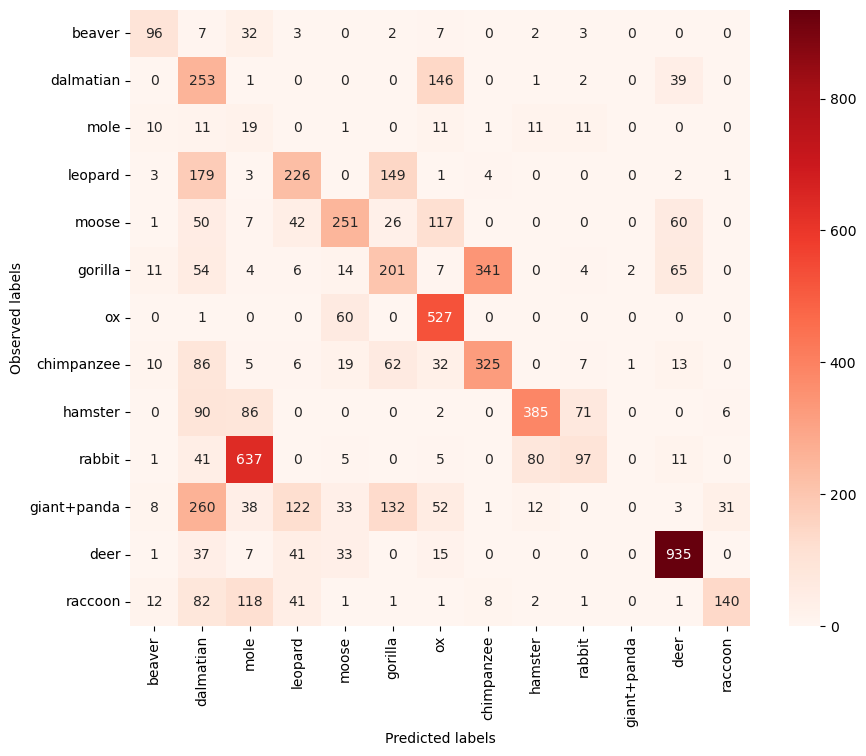

              precision    recall  f1-score   support

ARTIODACTYLA       0.81      0.90      0.85      2211
   CARNIVORA       0.73      0.63      0.68      2110
EULIPOTYPHLA       0.02      0.25      0.04        75
  LAGOMORPHA       0.49      0.11      0.18       877
    PRIMATES       0.74      0.73      0.73      1275
    RODENTIA       0.75      0.61      0.67       792

    accuracy                           0.66      7340
   macro avg       0.59      0.54      0.53      7340
weighted avg       0.72      0.66      0.67      7340

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.9036635  0.63270142 0.25333333 0.11060433 0.72862745 0.60984848]
Top_1_accuracy for UnSeen Validation split 01 -  0.5397964207658057


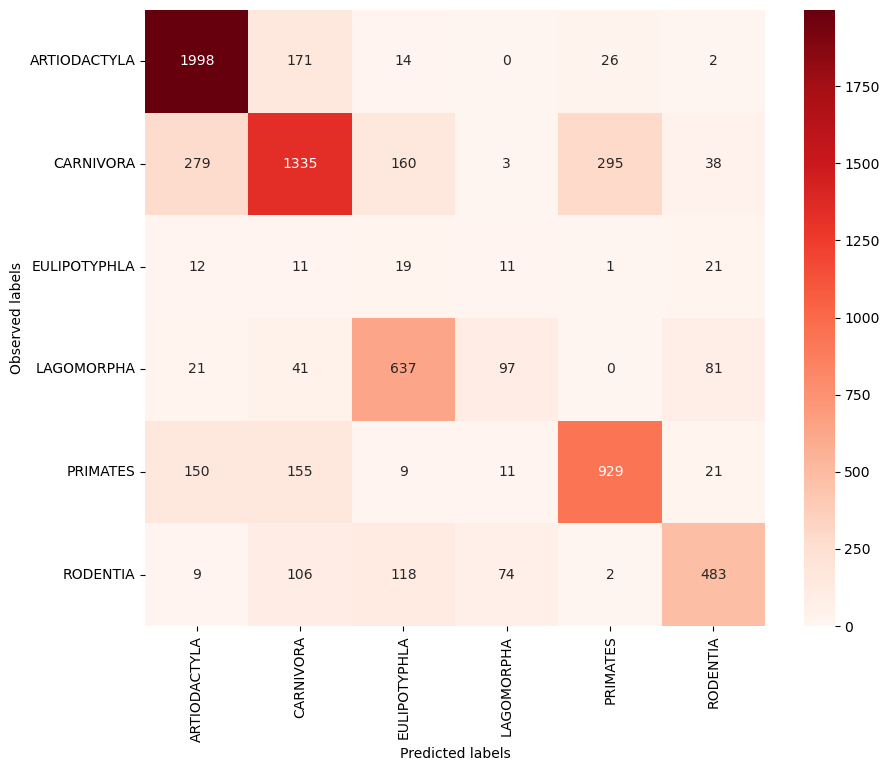

 Top- 2  Accuracy per class 
 Top- 2  Accuracy =  0.6481174559993594 
              0         1
0        beaver  0.750000
1     dalmatian  0.638009
2          mole  0.386667
3       leopard  0.709507
4         moose  0.743682
5       gorilla  0.757405
6            ox  0.998299
7    chimpanzee  0.674912
8       hamster  0.893750
9        rabbit  0.273660
10  giant+panda  0.007225
11         deer  0.923293
12      raccoon  0.669118 

 Top- 3  Accuracy per class 
 Top- 3  Accuracy =  0.780183460838461 
              0         1
0        beaver  0.796053
1     dalmatian  0.760181
2          mole  0.666667
3       leopard  0.827465
4         moose  0.792419
5       gorilla  0.892807
6            ox  1.000000
7    chimpanzee  0.772085
8       hamster  0.975000
9        rabbit  0.840365
10  giant+panda  0.056358
11         deer  0.954163
12      raccoon  0.808824 

 Top- 4  Accuracy per class 
 Top- 4  Accuracy =  0.8330519365299532 
              0         1
0        beaver  0.868421
1     d

(array([[-3.24264069, -4.29150262, -3.89897949, ..., -4.83095189,
         -4.83095189, -4.47722558],
        [-3.12310563, -4.38516481, -4.        , ..., -4.91607978,
         -4.74456265, -4.56776436],
        [-4.19615242, -4.38516481, -4.38516481, ..., -4.38516481,
         -4.91607978, -4.19615242],
        ...,
        [-4.38516481, -4.        , -3.35889894, ..., -4.74456265,
         -4.56776436, -3.35889894],
        [-4.09901951, -3.47213595, -3.89897949, ..., -4.83095189,
         -4.47722558, -3.47213595],
        [-3.89897949, -3.89897949, -2.74165739, ..., -3.89897949,
         -3.89897949, -3.24264069]]),
 array([ 4,  5, 12, 15, 16, 20, 21, 25, 26, 29, 39, 40, 48], dtype=int64),
 array(['beaver', 'dalmatian', 'mole', 'leopard', 'moose', 'gorilla', 'ox',
        'chimpanzee', 'hamster', 'rabbit', 'giant+panda', 'deer',
        'raccoon'], dtype=object))

In [25]:
CZSL(mode = 'Train', split = 1, C = 1.0 , kernal = 'rbf', gamma = 'scale', degree = 3,  pred_type = 'Deterministic', dist_type = 'euclidean')

#mode
#1. "Train" - Use Train Val split
#2. "Test" - For Unseen Test Data

#split
# 1 -Train/Val Split 1
# 2 -Train/Val Split 2
# 3 -Train/Val Split 2

#pred_type
#1. "Probabilistic" - continous real numbers giving probability for prdiction to be 1
#2. "Deterministic" - 1 or 0 prediction values

#dist_type
#1. euclidean
#2. cosine
#3. hamming
#4. jaccard

### 7.2 Train Validation Split 02

Execution time: 490.25092124938965 seconds
              precision    recall  f1-score   support

       black       0.97      0.98      0.98       974
       white       0.98      0.96      0.97       691
        blue       1.00      1.00      1.00        57
       brown       0.99      0.99      0.99      1173
        gray       0.98      0.98      0.98       778
      orange       1.00      0.97      0.99        70
         red       0.00      0.00      0.00         0
      yellow       1.00      0.98      0.99       139
     patches       0.97      0.98      0.98       737
       spots       0.98      0.95      0.96       382
     stripes       0.99      0.94      0.96       111
       furry       1.00      1.00      1.00      1421
    hairless       0.99      0.98      0.98       252
   toughskin       0.98      0.97      0.98       681
         big       0.99      1.00      1.00      1276
       small       0.98      0.98      0.98       535
     bulbous       0.98      0.98     

alt.LayerChart(...)

alt.LayerChart(...)

              precision    recall  f1-score   support

    antelope       0.64      0.98      0.78       864
grizzly+bear       0.84      0.50      0.63       690
killer+whale       0.97      0.75      0.85       231
      beaver       0.23      0.02      0.04       152
   dalmatian       0.35      0.62      0.45       442
 persian+cat       0.35      0.11      0.17       599
       skunk       0.16      0.27      0.20       157
          ox       0.43      0.93      0.59       588
         fox       0.48      0.63      0.55       540
   chihuahua       0.30      0.67      0.42       448
       otter       0.00      0.00      0.00       592
       zebra       0.99      0.52      0.68       942
         pig       0.14      0.05      0.07       558

    accuracy                           0.51      6803
   macro avg       0.45      0.47      0.42      6803
weighted avg       0.51      0.51      0.46      6803

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.9849537  0.502898

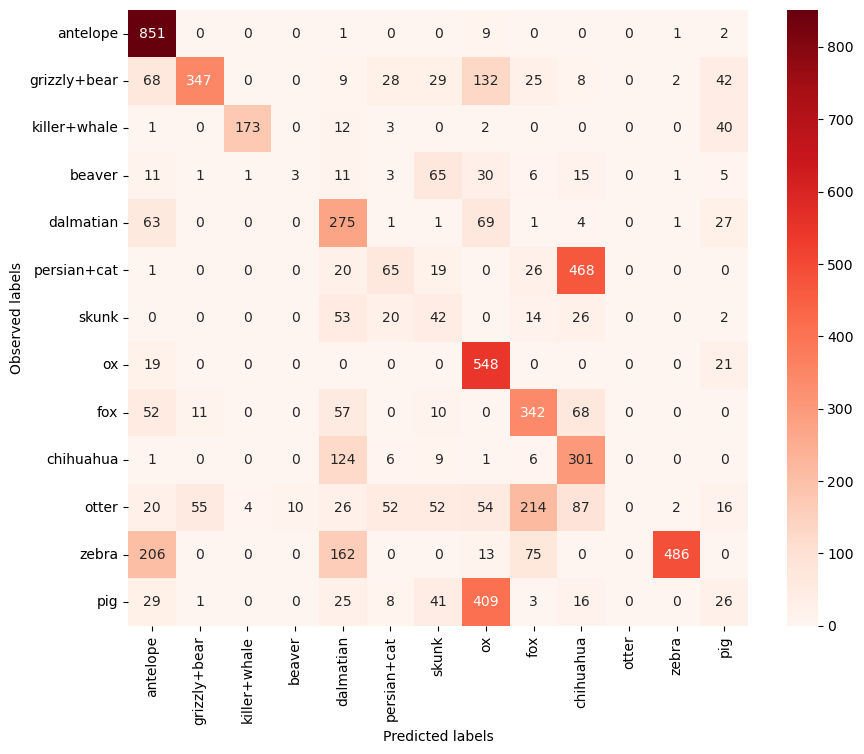

                precision    recall  f1-score   support

  ARTIODACTYLA       0.72      0.95      0.82      2241
     CARNIVORA       0.87      0.84      0.85      3468
PERISSODACTYLA       0.99      0.52      0.68       942
      RODENTIA       0.23      0.02      0.04       152

      accuracy                           0.81      6803
     macro avg       0.70      0.58      0.60      6803
  weighted avg       0.82      0.81      0.80      6803

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.95046854 0.83650519 0.51592357 0.01973684]
Top_1_accuracy for UnSeen Validation split 01 -  0.5806585350314124


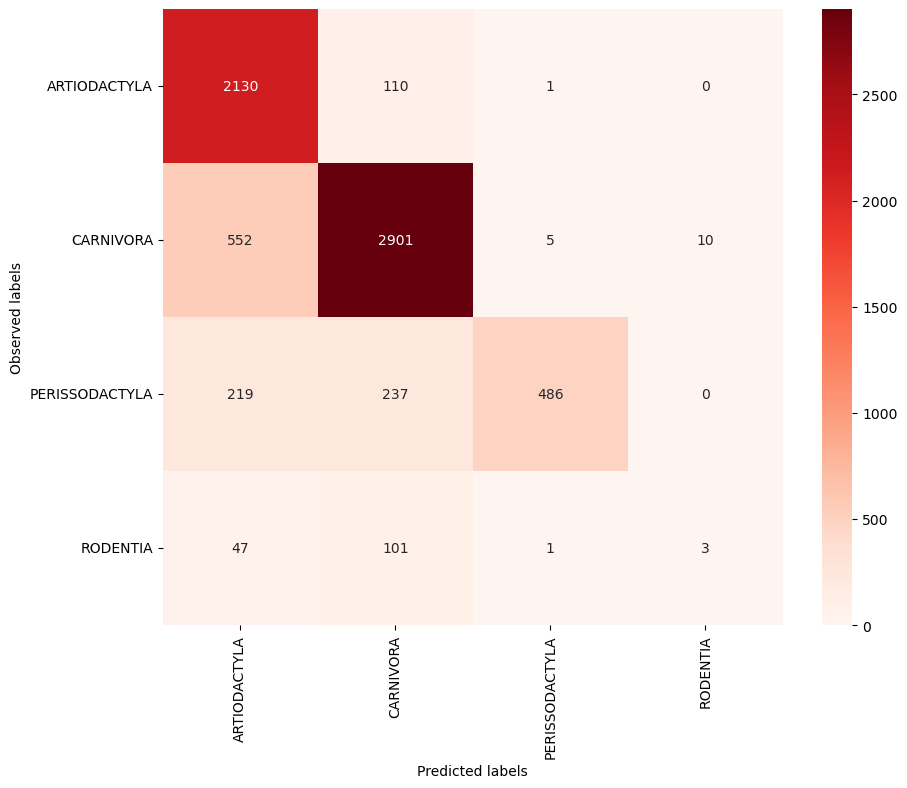

 Top- 2  Accuracy per class 
 Top- 2  Accuracy =  0.6647294243171414 
               0         1
0       antelope  0.986111
1   grizzly+bear  0.544928
2   killer+whale  0.766234
3         beaver  0.059211
4      dalmatian  0.687783
5    persian+cat  0.811352
6          skunk  0.464968
7             ox  0.996599
8            fox  0.783333
9      chihuahua  0.970982
10         otter  0.013514
11         zebra  0.873673
12           pig  0.682796 

 Top- 3  Accuracy per class 
 Top- 3  Accuracy =  0.7359661145287327 
               0         1
0       antelope  0.998843
1   grizzly+bear  0.605797
2   killer+whale  0.766234
3         beaver  0.118421
4      dalmatian  0.816742
5    persian+cat  0.939900
6          skunk  0.630573
7             ox  0.998299
8            fox  0.868519
9      chihuahua  0.984375
10         otter  0.048986
11         zebra  0.957537
12           pig  0.833333 

 Top- 4  Accuracy per class 
 Top- 4  Accuracy =  0.7983070389831286 
               0         1
0  

(array([[-1.82842712, -4.91607978, -5.32455532, ..., -4.83095189,
         -2.60555128, -4.        ],
        [-1.82842712, -4.91607978, -5.32455532, ..., -4.83095189,
         -2.60555128, -4.        ],
        [-1.82842712, -4.91607978, -5.32455532, ..., -4.83095189,
         -2.60555128, -4.        ],
        ...,
        [-4.09901951, -4.56776436, -5.32455532, ..., -4.65685425,
         -3.35889894, -4.74456265],
        [-3.35889894, -4.29150262, -5.08276253, ..., -4.56776436,
         -3.24264069, -4.47722558],
        [-3.47213595, -4.56776436, -5.32455532, ..., -4.09901951,
         -3.12310563, -4.56776436]]),
 array([ 1,  2,  3,  4,  5,  6, 11, 21, 22, 33, 36, 38, 42], dtype=int64),
 array(['antelope', 'grizzly+bear', 'killer+whale', 'beaver', 'dalmatian',
        'persian+cat', 'skunk', 'ox', 'fox', 'chihuahua', 'otter', 'zebra',
        'pig'], dtype=object))

In [26]:
CZSL(mode = 'Train', split = 2, C = 1.0 , kernal = 'rbf', gamma = 'scale', degree = 3,  pred_type = 'Deterministic', dist_type = 'euclidean')

#mode
#1. "Train" - Use Train Val split
#2. "Test" - For Unseen Test Data

#split
# 1 -Train/Val Split 1
# 2 -Train/Val Split 2
# 3 -Train/Val Split 3

#pred_type
#1. "Probabilistic" - continous real numbers giving probability for prdiction to be 1
#2. "Deterministic" - 1 or 0 prediction values

#dist_type
#1. euclidean
#2. cosine
#3. hamming
#4. jaccard

### 7.3 Train Validation Split 03

Execution time: 467.2531096935272 seconds
              precision    recall  f1-score   support

       black       0.97      0.98      0.98       918
       white       0.99      0.97      0.98       702
        blue       0.98      0.87      0.92        60
       brown       0.97      0.99      0.98      1025
        gray       0.96      0.94      0.95       451
      orange       0.99      0.99      0.99       124
         red       0.98      0.98      0.98        54
      yellow       1.00      0.96      0.98       139
     patches       0.95      0.95      0.95       566
       spots       0.94      0.92      0.93       339
     stripes       1.00      0.99      0.99       180
       furry       1.00      1.00      1.00      1463
    hairless       0.98      0.93      0.95       265
   toughskin       0.97      0.98      0.98       802
         big       0.99      0.99      0.99      1310
       small       0.98      0.96      0.97       396
     bulbous       0.98      0.99      

alt.LayerChart(...)

alt.LayerChart(...)

                precision    recall  f1-score   support

   siamese+cat       0.43      0.77      0.55       400
         moose       0.49      0.75      0.59       554
humpback+whale       0.99      0.95      0.97       565
    chimpanzee       0.82      0.91      0.86       566
      squirrel       0.52      0.30      0.38       961
    rhinoceros       0.84      0.71      0.77       561
        rabbit       0.52      0.75      0.62       877
          wolf       0.59      0.55      0.57       470
     chihuahua       0.37      0.27      0.31       448
        weasel       0.10      0.45      0.16       222
   giant+panda       0.00      0.00      0.00       692
           pig       0.58      0.48      0.53       558
       raccoon       0.38      0.01      0.01       408

      accuracy                           0.53      7282
     macro avg       0.51      0.53      0.49      7282
  weighted avg       0.53      0.53      0.50      7282

Top_1_accuracy for UnSeen Validation split 01

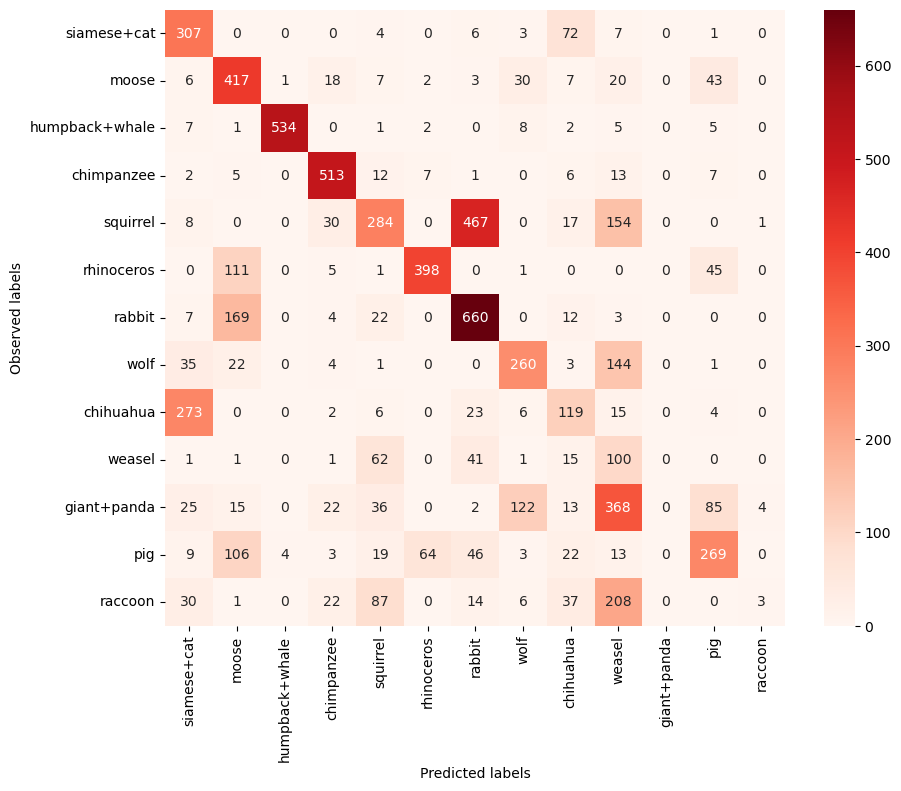

                precision    recall  f1-score   support

  ARTIODACTYLA       0.75      0.82      0.78      1677
     CARNIVORA       0.86      0.82      0.84      2640
    LAGOMORPHA       0.52      0.75      0.62       877
PERISSODACTYLA       0.84      0.71      0.77       561
      PRIMATES       0.82      0.91      0.86       566
      RODENTIA       0.52      0.30      0.38       961

      accuracy                           0.74      7282
     macro avg       0.72      0.72      0.71      7282
  weighted avg       0.74      0.74      0.74      7282

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.82289803 0.82462121 0.75256556 0.70944742 0.90636042 0.29552549]
Top_1_accuracy for UnSeen Validation split 01 -  0.7185696903967624


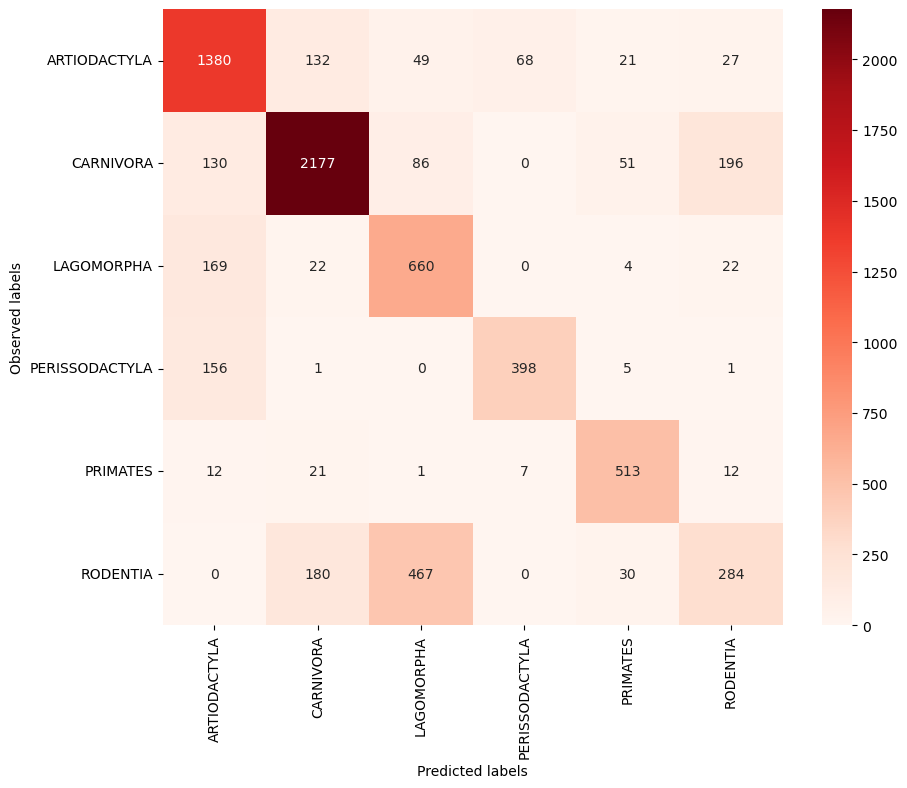

 Top- 2  Accuracy per class 
 Top- 2  Accuracy =  0.7165666884111709 
                 0         1
0      siamese+cat  0.935000
1            moose  0.848375
2   humpback+whale  0.959292
3       chimpanzee  0.916961
4         squirrel  0.870968
5       rhinoceros  0.819964
6           rabbit  0.864310
7             wolf  0.838298
8        chihuahua  0.859375
9           weasel  0.617117
10     giant+panda  0.001445
11             pig  0.740143
12         raccoon  0.044118 

 Top- 3  Accuracy per class 
 Top- 3  Accuracy =  0.7949518321655132 
                 0         1
0      siamese+cat  0.955000
1            moose  0.870036
2   humpback+whale  0.961062
3       chimpanzee  0.927562
4         squirrel  0.921956
5       rhinoceros  0.978610
6           rabbit  0.978335
7             wolf  0.910638
8        chihuahua  0.935268
9           weasel  0.900901
10     giant+panda  0.004335
11             pig  0.838710
12         raccoon  0.151961 

 Top- 4  Accuracy per class 
 Top- 4  Accura

(array([[-3.47213595, -3.79583152, -4.65685425, ..., -3.58257569,
         -3.        , -4.19615242],
        [-2.46410162, -4.38516481, -5.        , ..., -4.38516481,
         -4.29150262, -4.        ],
        [-2.74165739, -4.38516481, -4.65685425, ..., -4.38516481,
         -3.89897949, -4.        ],
        ...,
        [-3.69041576, -3.79583152, -5.        , ..., -4.19615242,
         -4.47722558, -4.        ],
        [-3.        , -4.56776436, -5.63324958, ..., -4.56776436,
         -4.83095189, -3.58257569],
        [-3.24264069, -4.91607978, -5.92820323, ..., -5.08276253,
         -5.32455532, -3.35889894]]),
 array([10, 16, 18, 25, 27, 28, 29, 32, 33, 35, 39, 42, 48], dtype=int64),
 array(['siamese+cat', 'moose', 'humpback+whale', 'chimpanzee', 'squirrel',
        'rhinoceros', 'rabbit', 'wolf', 'chihuahua', 'weasel',
        'giant+panda', 'pig', 'raccoon'], dtype=object))

In [27]:
CZSL(mode = 'Train', split = 3, C = 1.0 , kernal = 'rbf', gamma = 'scale', degree = 3,  pred_type = 'Deterministic', dist_type = 'euclidean')

#mode
#1. "Train" - Use Train Val split
#2. "Test" - For Unseen Test Data

#split
# 1 -Train/Val Split 1
# 2 -Train/Val Split 2
# 3 -Train/Val Split 2

#pred_type
#1. "Probabilistic" - continous real numbers giving probability for prdiction to be 1
#2. "Deterministic" - 1 or 0 prediction values

#dist_type
#1. euclidean
#2. cosine
#3. hamming
#4. jaccard

# 8. Hyperparameter Optimisation

In [29]:
import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):
    if __name__ == '__main__':
        # C
        svc_c = trial.suggest_loguniform('C', 1e0, 1e2)
        # kernel
        kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf'])
        # gamma
        gamma = trial.suggest_int("gamma", 1e0, 100, log=True)
        # degree
        degree = trial.suggest_int("degree", 1, 5, log=False)
        
        # SVC
        clf = OneVsRestClassifier(SVC(C=svc_c, kernel=kernel, gamma = gamma, degree = degree, random_state=100))
        
        
        SVM_01 = clf.fit(X_train1.astype(np.float32).values, y_train1.astype(np.float32).values)
        y_pred_val_unseen_01 = SVM_01.predict(ValData01.iloc[:,2:2050])
        predicatedf_ZSL01 = predicatedf[predicatedf['classes'].isin((ValData01.classes.unique()).tolist())]
        predicates = np.array(predicatedf_ZSL01.iloc[:,3:88])
        labels_01 = predicatedf_ZSL01['labels'].unique()
        dist = 1-distance.cdist(y_pred_val_unseen_01, predicates, 'cosine')
        predicted_classes_01 = np.array([np.argmax(output) for output in dist])
        replacements = {0:labels_01[0], 1:labels_01[1], 2:labels_01[2], 3:labels_01[3], 4:labels_01[4], 5:labels_01[5], 6:labels_01[6], 7:labels_01[7], 8:labels_01[8], 9:labels_01[9], 10:labels_01[10], 11:labels_01[11], 12:labels_01[12]}
        replacer = replacements.get  # For faster gets.
        predicted_classes_01  = [replacer(n, n) for n in predicted_classes_01]
        recall_score1 = recall_score(ValData01['labels'], predicted_classes_01, average = 'macro')
        
        SVM_02 = clf.fit(X_train2.astype(np.float32).values, y_train2.astype(np.float32).values)
        y_pred_val_unseen_02 = SVM_02.predict(ValData02.iloc[:,2:2050])
        predicatedf_ZSL02 = predicatedf[predicatedf['classes'].isin((ValData02.classes.unique()).tolist())]
        predicates2 = np.array(predicatedf_ZSL02.iloc[:,3:88])
        labels_02 = predicatedf_ZSL02['labels'].unique()
        dist2 = 1-distance.cdist(y_pred_val_unseen_02, predicates2, 'cosine')
        predicted_classes_02 = np.array([np.argmax(output) for output in dist2])
        replacements2 = {0:labels_02[0], 1:labels_02[1], 2:labels_02[2], 3:labels_02[3], 4:labels_02[4], 5:labels_02[5], 6:labels_02[6], 7:labels_02[7], 8:labels_02[8], 9:labels_02[9], 10:labels_02[10], 11:labels_02[11], 12:labels_02[12]}
        replacer2 = replacements2.get  # For faster gets.
        predicted_classes_02  = [replacer2(n, n) for n in predicted_classes_02]
        recall_score2 = recall_score(ValData02['labels'], predicted_classes_02, average = 'macro')
        
        SVM_03 = clf.fit(X_train3.astype(np.float32).values, y_train3.astype(np.float32).values)
        y_pred_val_unseen_03 = SVM_03.predict(ValData03.iloc[:,2:2050])
        predicatedf_ZSL03 = predicatedf[predicatedf['classes'].isin((ValData03.classes.unique()).tolist())]
        predicates3 = np.array(predicatedf_ZSL03.iloc[:,3:88])
        labels_03 = predicatedf_ZSL03['labels'].unique()
        dist3 = 1-distance.cdist(y_pred_val_unseen_03, predicates3, 'cosine')
        predicted_classes_03 = np.array([np.argmax(output) for output in dist3])
        replacements3 = {0:labels_03[0], 1:labels_03[1], 2:labels_03[2], 3:labels_03[3], 4:labels_03[4], 5:labels_03[5], 6:labels_03[6], 7:labels_03[7], 8:labels_03[8], 9:labels_03[9], 10:labels_03[10], 11:labels_03[11], 12:labels_03[12]}
        replacer3 = replacements3.get  # For faster gets.
        predicted_classes_03  = [replacer3(n, n) for n in predicted_classes_03]
        recall_score3 = recall_score(ValData03['labels'], predicted_classes_03, average = 'macro')
        
        
        results = [recall_score1,recall_score2,recall_score3]
        return np.mean(results)

st = time.time()
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5)
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
et = time.time()
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

[I 2022-10-22 14:18:29,903] A new study created in memory with name: no-name-ad50b4a5-16bd-4cf9-8214-5b0c636fd265
[I 2022-10-22 15:45:39,217] Trial 0 finished with value: 0.4793445976339235 and parameters: {'C': 3.4294608276894816, 'kernel': 'poly', 'gamma': 13}. Best is trial 0 with value: 0.4793445976339235.
[I 2022-10-22 16:17:23,199] Trial 1 finished with value: 0.07713939060343845 and parameters: {'C': 47.796423533331165, 'kernel': 'rbf', 'gamma': 74}. Best is trial 0 with value: 0.4793445976339235.
[I 2022-10-22 17:27:12,620] Trial 2 finished with value: 0.48824394371951896 and parameters: {'C': 21.854561182135228, 'kernel': 'poly', 'gamma': 1}. Best is trial 2 with value: 0.48824394371951896.
[I 2022-10-22 17:31:46,580] Trial 3 finished with value: 0.47437895789908874 and parameters: {'C': 57.903388616196814, 'kernel': 'linear', 'gamma': 83}. Best is trial 2 with value: 0.48824394371951896.
[I 2022-10-22 18:42:10,617] Trial 4 finished with value: 0.4567277283597491 and parameter

Number of finished trials: 5
Best trial:
  Value: 0.48824394371951896
  Params: 
    C: 21.854561182135228
    kernel: poly
    gamma: 1
Execution time: 15820.714292764664 seconds


# 9. Retrain LR with best parameters on three train val splits

### 9.1 Train Validation Split 01

Execution time: 2511.55047249794 seconds
              precision    recall  f1-score   support

       black       0.91      0.91      0.91       882
       white       0.58      0.97      0.73       678
        blue       0.40      0.62      0.48       117
       brown       0.95      0.93      0.94       950
        gray       0.84      0.99      0.91       739
      orange       0.98      0.97      0.97       124
         red       0.96      0.96      0.96        54
      yellow       1.00      0.99      0.99        82
     patches       0.82      0.83      0.82       390
       spots       0.96      0.91      0.93       187
     stripes       1.00      0.98      0.99       180
       furry       1.00      1.00      1.00      1288
    hairless       0.99      0.99      0.99       331
   toughskin       0.99      0.99      0.99       826
         big       0.99      0.99      0.99      1188
       small       0.87      1.00      0.93       512
     bulbous       0.91      0.43      0

alt.LayerChart(...)

alt.LayerChart(...)

              precision    recall  f1-score   support

      beaver       0.62      0.61      0.61       152
   dalmatian       0.35      0.69      0.46       442
        mole       0.03      0.28      0.05        75
     leopard       0.54      0.85      0.66       568
       moose       0.40      0.40      0.40       554
     gorilla       0.41      0.23      0.30       709
          ox       0.51      0.95      0.66       588
  chimpanzee       0.50      0.40      0.44       566
     hamster       0.54      0.58      0.56       640
      rabbit       0.16      0.03      0.05       877
 giant+panda       0.00      0.00      0.00       692
        deer       0.92      0.65      0.77      1069
     raccoon       0.51      0.63      0.56       408

    accuracy                           0.47      7340
   macro avg       0.42      0.48      0.42      7340
weighted avg       0.45      0.47      0.44      7340

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.60526316 0.687782

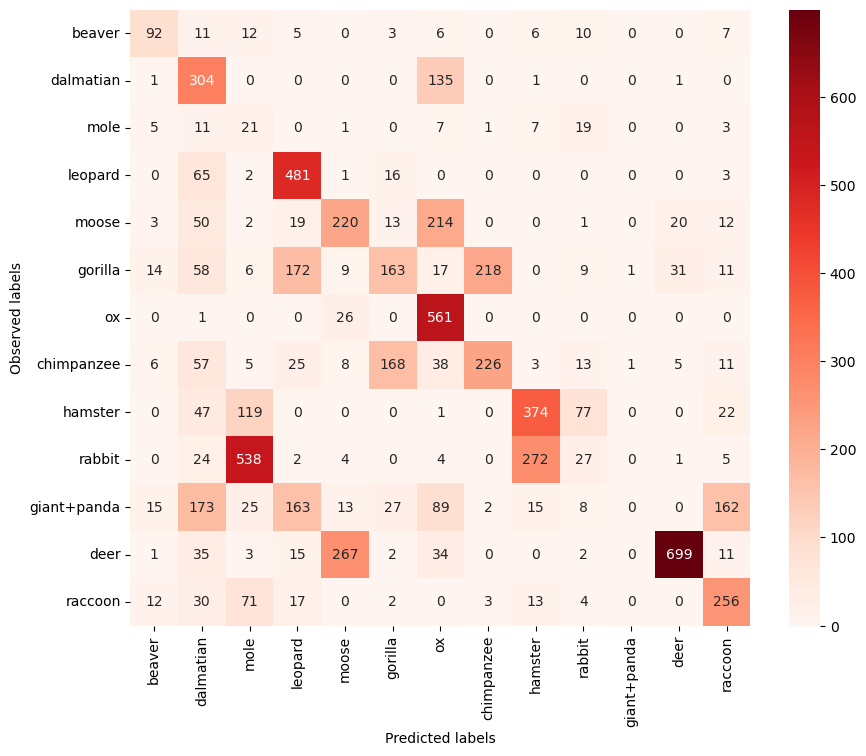

              precision    recall  f1-score   support

ARTIODACTYLA       0.85      0.92      0.88      2211
   CARNIVORA       0.73      0.78      0.76      2110
EULIPOTYPHLA       0.03      0.28      0.05        75
  LAGOMORPHA       0.16      0.03      0.05       877
    PRIMATES       0.92      0.61      0.73      1275
    RODENTIA       0.56      0.60      0.58       792

    accuracy                           0.68      7340
   macro avg       0.54      0.54      0.51      7340
weighted avg       0.70      0.68      0.68      7340

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.92311171 0.78388626 0.28       0.03078677 0.60784314 0.5959596 ]
Top_1_accuracy for UnSeen Validation split 01 -  0.5369312460642065


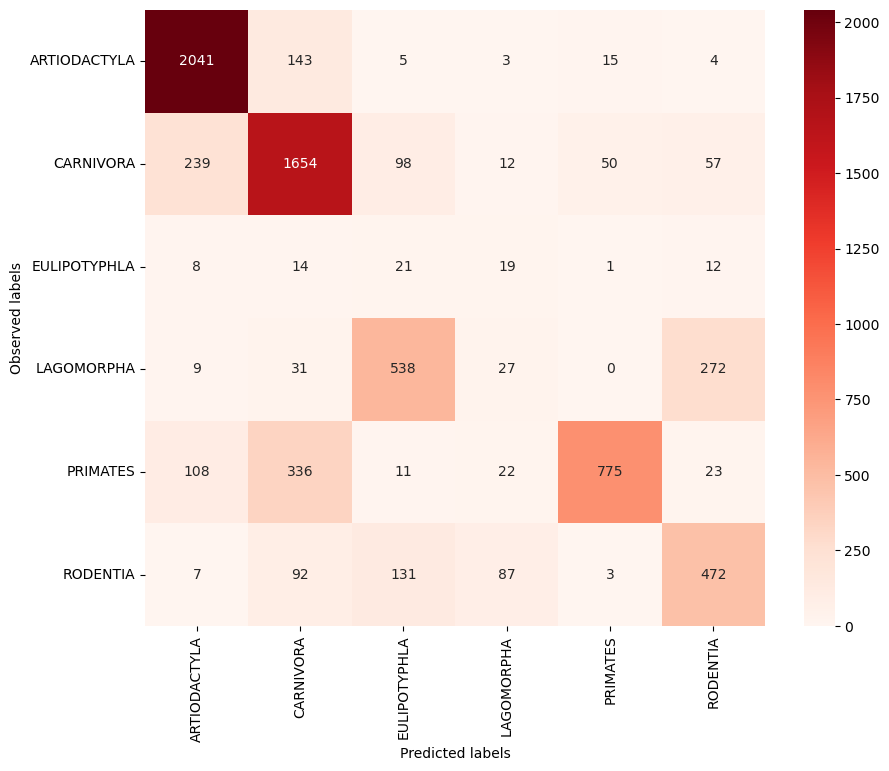

 Top- 2  Accuracy per class 
 Top- 2  Accuracy =  0.6544945669267089 
              0         1
0        beaver  0.618421
1     dalmatian  0.746606
2          mole  0.386667
3       leopard  0.915493
4         moose  0.756318
5       gorilla  0.605078
6            ox  0.996599
7    chimpanzee  0.643110
8       hamster  0.892188
9        rabbit  0.152794
10  giant+panda  0.008671
11         deer  0.913938
12      raccoon  0.872549 

 Top- 3  Accuracy per class 
 Top- 3  Accuracy =  0.7754842629271873 
              0         1
0        beaver  0.657895
1     dalmatian  0.839367
2          mole  0.666667
3       leopard  0.947183
4         moose  0.821300
5       gorilla  0.803949
6            ox  1.000000
7    chimpanzee  0.719081
8       hamster  0.976562
9        rabbit  0.705815
10  giant+panda  0.047688
11         deer  0.944808
12      raccoon  0.950980 

 Top- 4  Accuracy per class 
 Top- 4  Accuracy =  0.832044255217997 
              0         1
0        beaver  0.690789
1     d

(array([[-4.09901951, -3.47213595, -3.89897949, ..., -4.65685425,
         -4.65685425, -4.09901951],
        [-3.79583152, -4.56776436, -4.38516481, ..., -5.08276253,
         -5.08276253, -4.19615242],
        [-4.83095189, -4.09901951, -4.47722558, ..., -4.65685425,
         -4.83095189, -4.09901951],
        ...,
        [-4.65685425, -3.69041576, -3.89897949, ..., -4.83095189,
         -4.47722558, -3.24264069],
        [-4.09901951, -3.69041576, -3.69041576, ..., -5.        ,
         -4.47722558, -3.24264069],
        [-4.09901951, -4.09901951, -3.24264069, ..., -4.09901951,
         -4.47722558, -3.        ]]),
 array([ 4,  5, 12, 15, 16, 20, 21, 25, 26, 29, 39, 40, 48], dtype=int64),
 array(['beaver', 'dalmatian', 'mole', 'leopard', 'moose', 'gorilla', 'ox',
        'chimpanzee', 'hamster', 'rabbit', 'giant+panda', 'deer',
        'raccoon'], dtype=object))

In [20]:
CZSL(mode = 'Train', split = 1, C = 21.854561182135228 , kernel = 'poly', gamma = 1, degree = 3,  pred_type = 'Deterministic', dist_type = 'euclidean')

#mode
#1. "Train" - Use Train Val split
#2. "Test" - For Unseen Test Data

#split
# 1 -Train/Val Split 1
# 2 -Train/Val Split 2
# 3 -Train/Val Split 2

#pred_type
#1. "Probabilistic" - continous real numbers giving probability for prdiction to be 1
#2. "Deterministic" - 1 or 0 prediction values

#dist_type
#1. euclidean
#2. cosine
#3. hamming
#4. jaccard

### 9.2 Train Validation Split 02

Execution time: 4685.722520828247 seconds
              precision    recall  f1-score   support

       black       0.92      0.93      0.93       974
       white       0.91      0.89      0.90       691
        blue       1.00      1.00      1.00        57
       brown       0.99      0.99      0.99      1173
        gray       0.95      0.94      0.94       778
      orange       1.00      0.99      0.99        70
         red       0.00      0.00      0.00         0
      yellow       0.99      0.99      0.99       139
     patches       0.90      0.94      0.92       737
       spots       0.83      0.88      0.86       382
     stripes       0.97      0.98      0.98       111
       furry       1.00      1.00      1.00      1421
    hairless       1.00      0.98      0.99       252
   toughskin       0.94      0.94      0.94       681
         big       0.99      1.00      0.99      1276
       small       0.91      0.93      0.92       535
     bulbous       0.95      0.93      

alt.LayerChart(...)

alt.LayerChart(...)

              precision    recall  f1-score   support

    antelope       0.53      0.98      0.69       864
grizzly+bear       0.75      0.57      0.65       690
killer+whale       0.90      0.83      0.86       231
      beaver       0.38      0.05      0.09       152
   dalmatian       0.37      0.57      0.45       442
 persian+cat       0.50      0.29      0.36       599
       skunk       0.11      0.39      0.18       157
          ox       0.50      0.85      0.63       588
         fox       0.33      0.40      0.36       540
   chihuahua       0.29      0.46      0.36       448
       otter       0.00      0.00      0.00       592
       zebra       0.98      0.30      0.46       942
         pig       0.32      0.13      0.19       558

    accuracy                           0.47      6803
   macro avg       0.46      0.45      0.41      6803
weighted avg       0.50      0.47      0.44      6803

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.98148148 0.573913

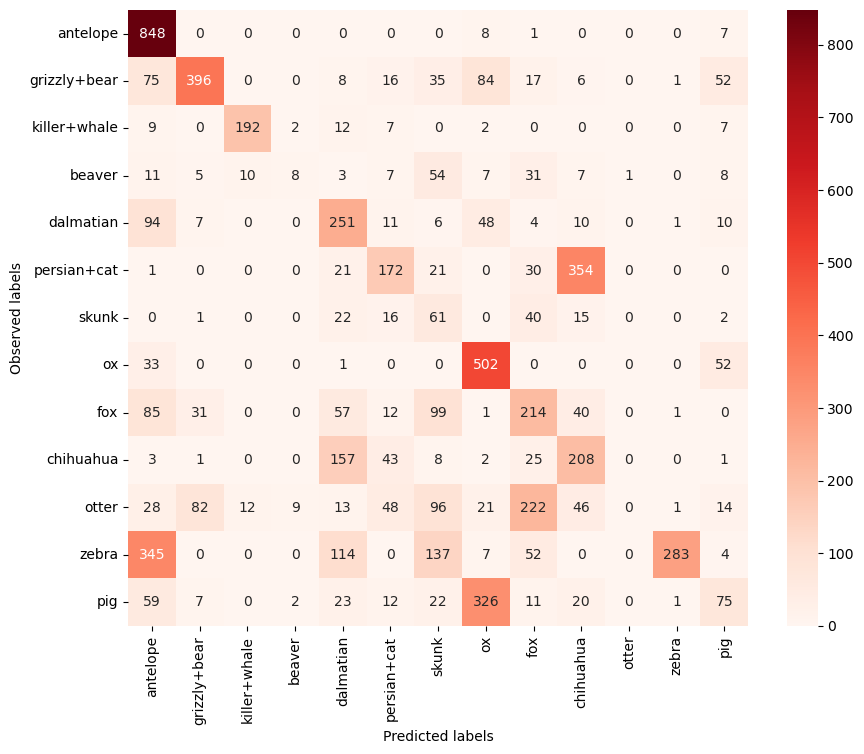

                precision    recall  f1-score   support

  ARTIODACTYLA       0.70      0.95      0.80      2241
     CARNIVORA       0.85      0.84      0.84      3468
PERISSODACTYLA       0.98      0.30      0.46       942
      RODENTIA       0.38      0.05      0.09       152

      accuracy                           0.78      6803
     macro avg       0.73      0.54      0.55      6803
  weighted avg       0.81      0.78      0.76      6803

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.94600625 0.84256055 0.30042463 0.05263158]
Top_1_accuracy for UnSeen Validation split 01 -  0.5354057520604398


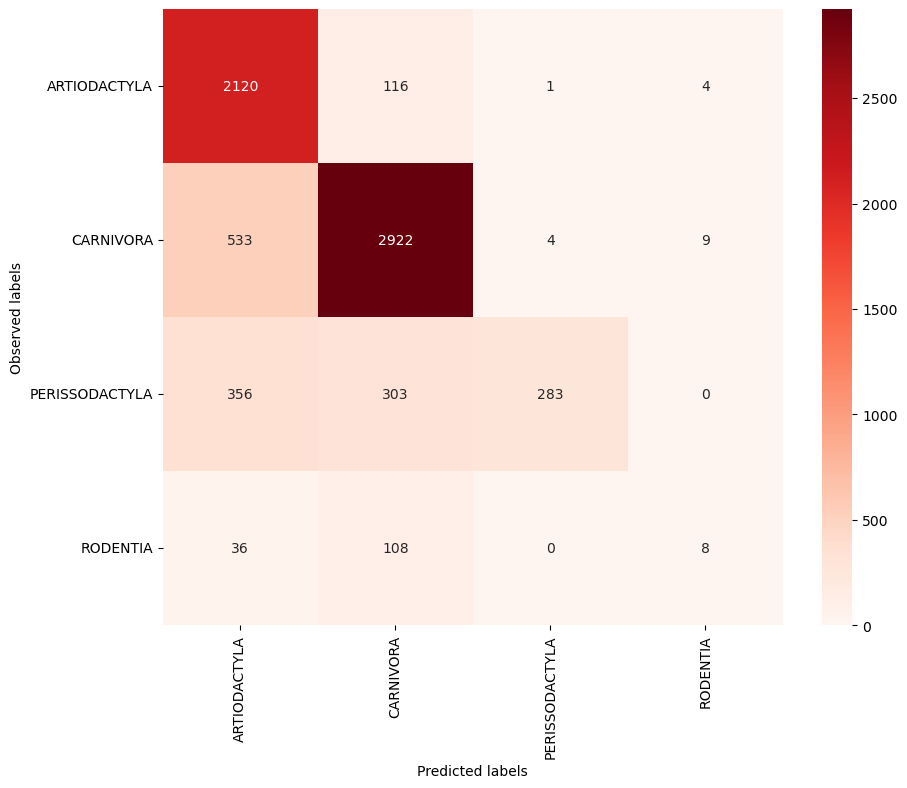

 Top- 2  Accuracy per class 
 Top- 2  Accuracy =  0.6251257952450728 
               0         1
0       antelope  0.984954
1   grizzly+bear  0.614493
2   killer+whale  0.844156
3         beaver  0.092105
4      dalmatian  0.631222
5    persian+cat  0.792988
6          skunk  0.503185
7             ox  0.981293
8            fox  0.553704
9      chihuahua  0.921875
10         otter  0.018581
11         zebra  0.562633
12           pig  0.625448 

 Top- 3  Accuracy per class 
 Top- 3  Accuracy =  0.7266833413095994 
               0         1
0       antelope  0.998843
1   grizzly+bear  0.691304
2   killer+whale  0.852814
3         beaver  0.164474
4      dalmatian  0.764706
5    persian+cat  0.948247
6          skunk  0.649682
7             ox  0.994898
8            fox  0.651852
9      chihuahua  0.979911
10         otter  0.101351
11         zebra  0.856688
12           pig  0.792115 

 Top- 4  Accuracy per class 
 Top- 4  Accuracy =  0.7851374943604946 
               0         1
0  

(array([[-2.31662479, -4.83095189, -5.70820393, ..., -4.91607978,
         -3.24264069, -3.69041576],
        [-1.82842712, -4.91607978, -5.32455532, ..., -4.83095189,
         -2.60555128, -4.        ],
        [-2.        , -5.        , -5.244998  , ..., -4.74456265,
         -2.74165739, -4.09901951],
        ...,
        [-4.19615242, -4.65685425, -5.08276253, ..., -4.74456265,
         -3.89897949, -4.65685425],
        [-3.35889894, -4.83095189, -5.40312424, ..., -4.56776436,
         -3.47213595, -3.69041576],
        [-3.47213595, -5.08276253, -5.164414  , ..., -4.65685425,
         -2.87298335, -4.91607978]]),
 array([ 1,  2,  3,  4,  5,  6, 11, 21, 22, 33, 36, 38, 42], dtype=int64),
 array(['antelope', 'grizzly+bear', 'killer+whale', 'beaver', 'dalmatian',
        'persian+cat', 'skunk', 'ox', 'fox', 'chihuahua', 'otter', 'zebra',
        'pig'], dtype=object))

In [21]:
CZSL(mode = 'Train', split = 2, C = 21.854561182135228 , kernel = 'poly', gamma = 1, degree = 3,  pred_type = 'Deterministic', dist_type = 'euclidean')

#mode
#1. "Train" - Use Train Val split
#2. "Test" - For Unseen Test Data

#split
# 1 -Train/Val Split 1
# 2 -Train/Val Split 2
# 3 -Train/Val Split 2

#pred_type
#1. "Probabilistic" - continous real numbers giving probability for prdiction to be 1
#2. "Deterministic" - 1 or 0 prediction values

#dist_type
#1. euclidean
#2. cosine
#3. hamming
#4. jaccard

### 9.3 Train Validation Split 03

Execution time: 2629.294003725052 seconds
              precision    recall  f1-score   support

       black       0.90      0.92      0.91       918
       white       0.92      0.89      0.90       702
        blue       0.93      0.92      0.92        60
       brown       0.93      0.85      0.89      1025
        gray       0.42      0.65      0.51       451
      orange       0.97      0.98      0.97       124
         red       0.93      0.94      0.94        54
      yellow       0.98      0.97      0.97       139
     patches       0.78      0.92      0.84       566
       spots       0.31      0.66      0.43       339
     stripes       0.99      0.98      0.99       180
       furry       1.00      1.00      1.00      1463
    hairless       0.83      0.75      0.79       265
   toughskin       0.69      0.84      0.75       802
         big       0.99      0.99      0.99      1310
       small       0.83      0.89      0.86       396
     bulbous       0.99      0.99      

alt.LayerChart(...)

alt.LayerChart(...)

                precision    recall  f1-score   support

   siamese+cat       0.28      0.75      0.41       400
         moose       0.48      0.70      0.57       554
humpback+whale       0.98      0.93      0.96       565
    chimpanzee       0.85      0.87      0.86       566
      squirrel       0.51      0.23      0.31       961
    rhinoceros       0.80      0.52      0.63       561
        rabbit       0.51      0.81      0.63       877
          wolf       0.45      0.21      0.29       470
     chihuahua       0.34      0.21      0.26       448
        weasel       0.08      0.30      0.13       222
   giant+panda       0.72      0.06      0.10       692
           pig       0.44      0.49      0.46       558
       raccoon       0.30      0.09      0.13       408

      accuracy                           0.49      7282
     macro avg       0.52      0.47      0.44      7282
  weighted avg       0.56      0.49      0.46      7282

Top_1_accuracy for UnSeen Validation split 01

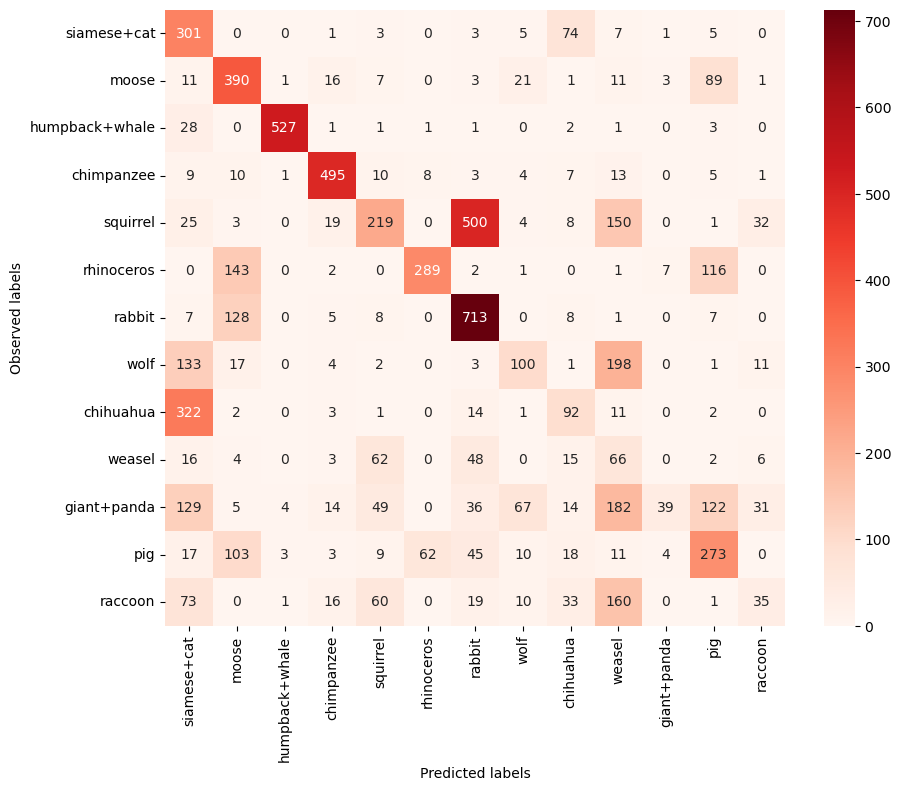

                precision    recall  f1-score   support

  ARTIODACTYLA       0.71      0.83      0.76      1677
     CARNIVORA       0.84      0.81      0.82      2640
    LAGOMORPHA       0.51      0.81      0.63       877
PERISSODACTYLA       0.80      0.52      0.63       561
      PRIMATES       0.85      0.87      0.86       566
      RODENTIA       0.51      0.23      0.31       961

      accuracy                           0.72      7282
     macro avg       0.70      0.68      0.67      7282
  weighted avg       0.72      0.72      0.71      7282

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.82826476 0.80795455 0.81299886 0.51515152 0.8745583  0.22788762]
Top_1_accuracy for UnSeen Validation split 01 -  0.6778025999675007


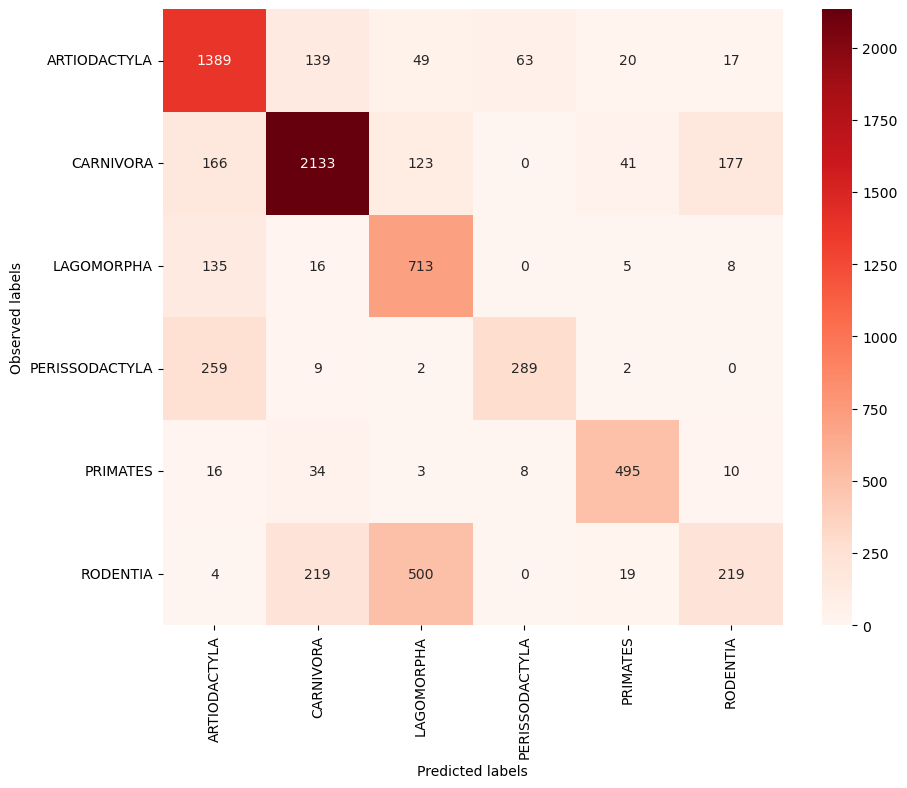

 Top- 2  Accuracy per class 
 Top- 2  Accuracy =  0.6949753110364383 
                 0         1
0      siamese+cat  0.932500
1            moose  0.853791
2   humpback+whale  0.953982
3       chimpanzee  0.906360
4         squirrel  0.788762
5       rhinoceros  0.748663
6           rabbit  0.905359
7             wolf  0.470213
8        chihuahua  0.850446
9           weasel  0.527027
10     giant+panda  0.143064
11             pig  0.743728
12         raccoon  0.210784 

 Top- 3  Accuracy per class 
 Top- 3  Accuracy =  0.7926809495578259 
                 0         1
0      siamese+cat  0.955000
1            moose  0.900722
2   humpback+whale  0.959292
3       chimpanzee  0.925795
4         squirrel  0.850156
5       rhinoceros  0.957219
6           rabbit  0.956670
7             wolf  0.619149
8        chihuahua  0.955357
9           weasel  0.738739
10     giant+panda  0.238439
11             pig  0.851254
12         raccoon  0.397059 

 Top- 4  Accuracy per class 
 Top- 4  Accura

(array([[-3.58257569, -3.89897949, -4.56776436, ..., -4.47722558,
         -3.58257569, -4.65685425],
        [-2.87298335, -4.47722558, -5.244998  , ..., -3.89897949,
         -4.        , -3.89897949],
        [-3.12310563, -4.47722558, -5.244998  , ..., -4.83095189,
         -4.38516481, -4.29150262],
        ...,
        [-3.58257569, -4.47722558, -5.244998  , ..., -4.47722558,
         -4.91607978, -3.69041576],
        [-3.12310563, -5.        , -5.70820393, ..., -5.        ,
         -4.91607978, -3.47213595],
        [-3.12310563, -5.164414  , -6.        , ..., -5.        ,
         -5.08276253, -3.24264069]]),
 array([10, 16, 18, 25, 27, 28, 29, 32, 33, 35, 39, 42, 48], dtype=int64),
 array(['siamese+cat', 'moose', 'humpback+whale', 'chimpanzee', 'squirrel',
        'rhinoceros', 'rabbit', 'wolf', 'chihuahua', 'weasel',
        'giant+panda', 'pig', 'raccoon'], dtype=object))

In [22]:
CZSL(mode = 'Train', split = 3, C = 21.854561182135228 , kernel = 'poly', gamma = 1, degree = 3,  pred_type = 'Deterministic', dist_type = 'euclidean')

#mode
#1. "Train" - Use Train Val split
#2. "Test" - For Unseen Test Data

#split
# 1 -Train/Val Split 1
# 2 -Train/Val Split 2
# 3 -Train/Val Split 2

#pred_type
#1. "Probabilistic" - continous real numbers giving probability for prdiction to be 1
#2. "Deterministic" - 1 or 0 prediction values

#dist_type
#1. euclidean
#2. cosine
#3. hamming
#4. jaccard

# 10. Retrain SVM with best parameters on full data

Execution time: 13152.303688764572 seconds
Unseen Class Labels
[ 7  9 23 24 30 31 34 41 47 50]
t-SNE spatialisation of Unseen Classes
[t-SNE] Computing 9 nearest neighbors...
[t-SNE] Indexed 10 samples in 0.000s...
[t-SNE] Computed neighbors for 10 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 10 / 10
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.898930
[t-SNE] KL divergence after 1000 iterations: 0.250724


alt.LayerChart(...)

alt.LayerChart(...)

              precision    recall  f1-score   support

       horse       0.20      0.19      0.19      1645
  blue+whale       0.12      0.99      0.21       174
       sheep       0.41      0.71      0.52      1420
        seal       0.63      0.22      0.32       988
         bat       1.00      0.01      0.01       383
     giraffe       0.38      0.23      0.29      1202
         rat       0.37      0.52      0.43       310
      bobcat       0.75      0.80      0.77       630
      walrus       0.13      0.07      0.09       215
     dolphin       0.12      0.02      0.03       946

    accuracy                           0.34      7913
   macro avg       0.41      0.38      0.29      7913
weighted avg       0.39      0.34      0.31      7913

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.18601824 0.99425287 0.71267606 0.21659919 0.00522193 0.23211314
 0.51935484 0.7984127  0.06976744 0.02008457]
Top_1_accuracy for UnSeen Validation split 01 -  0.3754500979719368


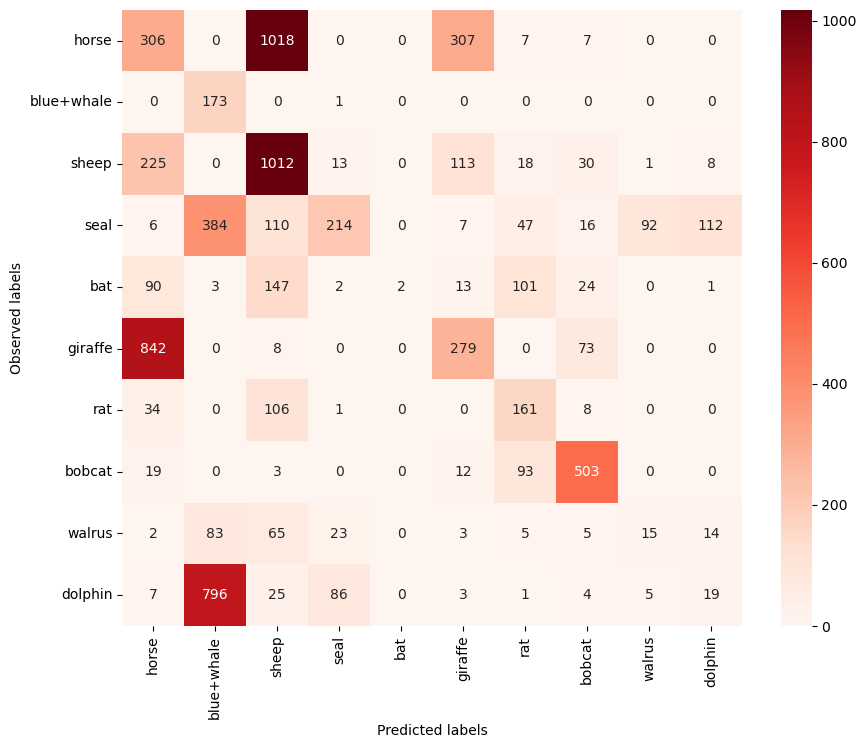

                precision    recall  f1-score   support

  ARTIODACTYLA       0.50      0.65      0.57      3742
     CARNIVORA       0.77      0.47      0.59      1833
    CHIROPTERA       1.00      0.01      0.01       383
PERISSODACTYLA       0.20      0.19      0.19      1645
      RODENTIA       0.37      0.52      0.43       310

      accuracy                           0.48      7913
     macro avg       0.57      0.37      0.36      7913
  weighted avg       0.52      0.48      0.46      7913

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.65098878 0.47354064 0.00522193 0.18601824 0.51935484]
Top_1_accuracy for UnSeen Validation split 01 -  0.3670248855431244


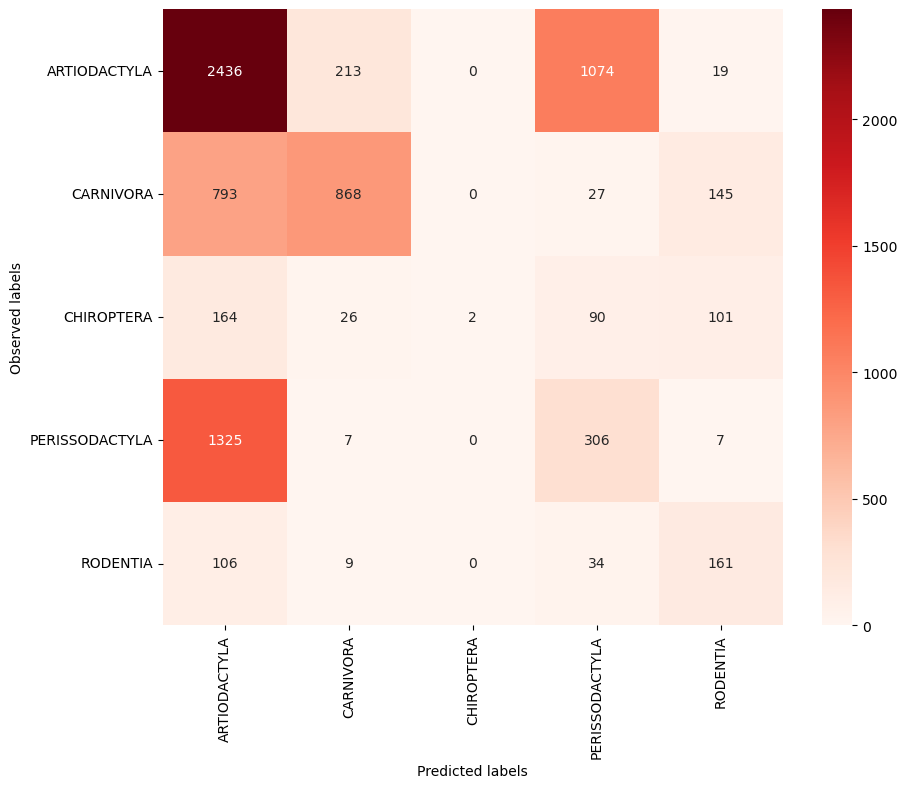

 Top- 2  Accuracy per class 
 Top- 2  Accuracy =  0.6068823099245139 
            0         1
0       horse  0.550152
1  blue+whale  0.982759
2       sheep  0.830986
3        seal  0.367409
4         bat  0.023499
5     giraffe  0.912646
6         rat  0.803226
7      bobcat  0.947619
8      walrus  0.306977
9     dolphin  0.343552 

 Top- 3  Accuracy per class 
 Top- 3  Accuracy =  0.7621236732390892 
            0         1
0       horse  0.998176
1  blue+whale  1.000000
2       sheep  0.954930
3        seal  0.575911
4         bat  0.041775
5     giraffe  0.957571
6         rat  0.980645
7      bobcat  0.968254
8      walrus  0.409302
9     dolphin  0.734672 

 Top- 4  Accuracy per class 
 Top- 4  Accuracy =  0.8453432857970951 
            0         1
0       horse  1.000000
1  blue+whale  1.000000
2       sheep  0.977465
3        seal  0.767206
4         bat  0.127937
5     giraffe  0.982529
6         rat  0.987097
7      bobcat  0.993651
8      walrus  0.641860
9     dolphin  0.9

In [24]:
SVM_binary_animal_attributes = CZSL(mode = 'Test', split = 1, C = 21.854561182135228 , kernel = 'poly', gamma = 1, degree = 3,  pred_type = 'Deterministic', dist_type = 'euclidean')

#mode
#1. "Train" - Use Train Val split
#2. "Test" - For Unseen Test Data

#split
# 1 -Train/Val Split 1
# 2 -Train/Val Split 2
# 3 -Train/Val Split 2

#pred_type
#1. "Probabilistic" - continous real numbers giving probability for prdiction to be 1
#2. "Deterministic" - 1 or 0 prediction values

#dist_type
#1. euclidean
#2. cosine
#3. hamming
#4. jaccard

# 5. Save final ZSL Model

In [ ]:
# save the model to disk
import pickle
filename = 'C:/Dissertation/Models/SVM_Binary_Animal_Attributes_ZSL'
pickle.dump(SVM_binary_animal_attributes, open(filename, 'wb'))